In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F

In [2]:
# reading input data
with open("../data/tinyshakespeare.txt", "r", encoding="utf-8") as file:
    data = file.read()

In [3]:
print(f"Length of dataset w.r.t chars: {len(data)}\n")
print(data[:1000])

Length of dataset w.r.t chars: 1115394

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger

In [4]:
# all unique chars
chars = sorted(list(set(data)))
vocab_size = len(chars)
print("".join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [5]:
# tokenization (mapping for char to int)
ch_to_id = {ch:i for i, ch in enumerate(chars)}
id_to_ch = {i:ch for i, ch in enumerate(chars)}
def encode(s):
    return [ch_to_id[c] for c in s] # encoder: take a string, output a list of integers
def decode(l):
    return ''.join([id_to_ch[i] for i in l]) # decoder: take a list of integers, output a string

# tests
print(encode("Hello world!"))
print(decode(encode("Hello World!")))

[20, 43, 50, 50, 53, 1, 61, 53, 56, 50, 42, 2]
Hello World!


In [6]:
# tokenizing enitire dataset and converting them into tensors
data = torch.tensor(encode(data), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:1000]) # 1st 1000 char tensors

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
      

In [7]:
# train, val split
thresh = int(0.9 * len(data))
train_data = data[:thresh] # 90%
val_data = data[thresh:] # 10%

In [8]:
# dataloader: outs batches of x and y pairs
batch_size = 4 # n sequence to process parallaly
block_size = 8 # context length

def get_batches(split):
    """
    generate batched in and out pairs
    """
    data = train_data if split == "train" else val_data
    idx = torch.randint(len(data) - block_size, (batch_size, ))
    x = torch.stack([data[i:i + block_size] for i in idx])
    y = torch.stack([data[i + 1: i + block_size + 1] for i in idx])
    return x, y

mini_x, mini_y = get_batches("train") # batch
print(f"Inputs shape: {mini_x.shape}\nInputs: {mini_x}\n")
print(f"Target shape: {mini_y.shape}\nTarget: {mini_y}\n")
print("--------------------------------------------------\n")

# insights into the batched data
for b in range(batch_size):
    for t in range(block_size):
        context = mini_x[b, :t+1]
        target = mini_y[b, t]
        print(f"Input: {context.tolist()}, Target: {target}")

Inputs shape: torch.Size([4, 8])
Inputs: tensor([[ 0,  5, 32, 47, 57,  1, 52, 53],
        [27, 56,  1, 40, 43, 52, 42,  1],
        [43,  1, 24, 53, 56, 42, 10,  0],
        [46, 43, 56,  8,  0,  0, 14, 53]])

Target shape: torch.Size([4, 8])
Target: tensor([[ 5, 32, 47, 57,  1, 52, 53, 58],
        [56,  1, 40, 43, 52, 42,  1, 53],
        [ 1, 24, 53, 56, 42, 10,  0, 18],
        [43, 56,  8,  0,  0, 14, 53, 58]])

--------------------------------------------------

Input: [0], Target: 5
Input: [0, 5], Target: 32
Input: [0, 5, 32], Target: 47
Input: [0, 5, 32, 47], Target: 57
Input: [0, 5, 32, 47, 57], Target: 1
Input: [0, 5, 32, 47, 57, 1], Target: 52
Input: [0, 5, 32, 47, 57, 1, 52], Target: 53
Input: [0, 5, 32, 47, 57, 1, 52, 53], Target: 58
Input: [27], Target: 56
Input: [27, 56], Target: 1
Input: [27, 56, 1], Target: 40
Input: [27, 56, 1, 40], Target: 43
Input: [27, 56, 1, 40, 43], Target: 52
Input: [27, 56, 1, 40, 43, 52], Target: 42
Input: [27, 56, 1, 40, 43, 52, 42], Target:

In [18]:
# bigram class
class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):
        # idx and targets are both (B,T) tensor of integers batch, time/context
        logits = self.token_embedding_table(idx) # (B,T,C)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self(idx)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx
    
    def sample(self, idx, max_new_tokens):
        return decode(self.generate(idx, max_new_tokens)[0].tolist())
    
bigram_model = BigramLanguageModel(vocab_size)
logits, loss = bigram_model(mini_x, mini_y)
print(f"Loss: {loss}")

Loss: 4.807022571563721


In [45]:
# prediction before training
print(bigram_model.sample(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100))


QSxVTLCvqSNeN?'j
keCNY-T
dteYGAeW&f$Jx;z3UBSeAHsL&
KuIZkIp$,cLLfHVT,'ZbW.TI:ukL.HZpSbwPSCyifaEdg!.HH


In [ ]:
# # predictions before training
# print(decode(bigram_model.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))

In [46]:
# optimizer
optimizer = torch.optim.AdamW(bigram_model.parameters(), lr=1e-3)

In [47]:
# Training bigram model
batch_size = 32
epochs = 10000

for epoch in range(epochs):
    # getting batches
    xb, yb = get_batches("train")
    
    # loss
    logits, loss = bigram_model(xb, yb)
    
    # setting grad to zero
    optimizer.zero_grad(set_to_none=True)
    
    # backprop
    loss.backward()
    
    # update params
    optimizer.step()
    if (epoch+1) % 1000 == 0:
        print(f"Epoch: {epoch+1}, Loss: {loss.item()}")

Epoch: 1000, Loss: 3.8054986000061035
Epoch: 2000, Loss: 3.324122667312622
Epoch: 3000, Loss: 2.8780388832092285
Epoch: 4000, Loss: 2.6557414531707764
Epoch: 5000, Loss: 2.6466286182403564
Epoch: 6000, Loss: 2.3895211219787598
Epoch: 7000, Loss: 2.5135180950164795
Epoch: 8000, Loss: 2.5664174556732178
Epoch: 9000, Loss: 2.5909507274627686
Epoch: 10000, Loss: 2.3946382999420166


In [51]:
# prediction after training
print(bigram_model.sample(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=500))


Angty, host wiccerth ir wndeanstJou bur dy sons KI in, l all alertstud tt
IN:
Whaibeeasor wado s;
FO fthenckithigherevey thooures;
veionnd hece hel agh e o, ldurero gle t h f secousengharsar.


O:
LOUt t infercut phe be ness;
TXger.
Wayofay p,
Hal torisou hmand ms athondlouelee w'TI t s.

WA:
HAn ird sea pravear ur,
Aco rinden.
Ound leOF:
Whe, it
Thais id!
s st bouce sisilmaknorrsad ome Gondss:
MEve I knomelx homurete ISEThe;
Mans, yowe ayoure chinof hearerathean, slavin f ie tof is Thre hey rin


In [ ]:
# # predictions after training
# print(decode(bigram_model.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=500)[0].tolist()))

In [57]:
# intuition for masked self-attention
B, T, C = 4, 8, 2 # Batch, Time(context length), Channels(embeddings or info at B,T)
x = torch.randn(B, T, C)
print(f"x Shape: {x.shape}")

# we want ith token to have attention to all tokens from i-T to i
# hence x[b, t] = mean of i<t x[b, i]
xbow = torch.zeros((B, T, C)) # averaging
for b in range(B):
    for t in range(T):
        xprev = x[b, :t+1] # (t, C)
        xbow[b, t] = torch.mean(xprev, 0)
x[0], xbow[0]

x Shape: torch.Size([4, 8, 2])


(tensor([[ 0.5278,  0.8184],
         [-0.0731,  0.0911],
         [-0.2688,  0.6280],
         [ 0.5763, -0.3307],
         [ 1.2834,  0.6111],
         [ 0.3370, -1.1037],
         [-0.4783, -0.1251],
         [-0.5722, -2.0273]]),
 tensor([[ 0.5278,  0.8184],
         [ 0.2274,  0.4547],
         [ 0.0620,  0.5125],
         [ 0.1906,  0.3017],
         [ 0.4091,  0.3636],
         [ 0.3971,  0.1190],
         [ 0.2721,  0.0842],
         [ 0.1665, -0.1798]]))

In [65]:
# masked self-attention using matrix multiplication
weights = torch.tril(torch.ones(T, T)) # lower triangular matrix
weights = weights / weights.sum(1, keepdim=True) # row normalization
print("Weights for self-attention: \n", weights)
xbow2 =  weights @ x # (B, T, T) @ (B, T, C) = (B, T, C), here the weights are averaging the context so that the ith token has attention to all tokens from i-T to i
torch.allclose(xbow, xbow2) # tells if the two tensors are equal

Weights for self-attention: 
 tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])


True

In [66]:
# masked self-attention using softmax
tril = torch.tril(torch.ones(T, T)) # lower triangular matrix
weights = torch.zeros((T, T))
weights = weights.masked_fill(tril == 0, float('-inf')) # masking the upper triangular part
print(f"Weights before softmax: \n{weights}\n")
weights = F.softmax(weights, dim=1) # row normalization
print(f"Weights after softmax: \n{weights}")

Weights before softmax: 
tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

Weights after softmax: 
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250

In [71]:
# masked self-attention (CRUX)
B,T,C = 4,8,32 # batch, time, channels
x = torch.randn(B,T,C)

# single headed masked self-attention
head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(x)   # (B, T, 16)
q = query(x) # (B, T, 16)
weights =  q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) ---> (B, T, T)

tril = torch.tril(torch.ones(T, T))
weights = weights.masked_fill(tril == 0, float('-inf'))
weights = F.softmax(weights, dim=-1)

v = value(x)
out = weights @ v

print(f"Output shape: {out.shape}")
print(f"Weight: \n{weights[0]}")

Output shape: torch.Size([4, 8, 16])
Weight: 
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.9597, 0.0403, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2115, 0.3150, 0.4735, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.7466, 0.0461, 0.1186, 0.0887, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.7403, 0.0438, 0.1595, 0.0345, 0.0220, 0.0000, 0.0000, 0.0000],
        [0.1442, 0.0878, 0.1484, 0.2169, 0.0440, 0.3587, 0.0000, 0.0000],
        [0.1155, 0.0253, 0.0772, 0.0600, 0.1738, 0.0938, 0.4544, 0.0000],
        [0.2619, 0.2991, 0.1837, 0.0366, 0.1346, 0.0585, 0.0118, 0.0138]],
       grad_fn=<SelectBackward0>)


In [73]:
# scaled masked self-attention
head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(x)   # (B, T, 16)
q = query(x) # (B, T, 16)
weights =  q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) ---> (B, T, T)

tril = torch.tril(torch.ones(T, T))
weights = weights.masked_fill(tril == 0, float('-inf'))
weights = F.softmax(weights / (head_size ** 0.5), dim=-1) # scaling helps the softmax to be more stable and less sensitive to large values

v = value(x)
out = weights @ v

print(f"Output shape: {out.shape}")
print(f"Weight: \n{weights[0]}")

Output shape: torch.Size([4, 8, 16])
Weight: 
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3894, 0.6106, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4886, 0.3219, 0.1895, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2701, 0.2011, 0.2403, 0.2886, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1699, 0.1995, 0.1886, 0.1928, 0.2492, 0.0000, 0.0000, 0.0000],
        [0.1926, 0.1632, 0.1158, 0.1620, 0.2331, 0.1334, 0.0000, 0.0000],
        [0.1786, 0.1895, 0.1435, 0.1346, 0.1440, 0.1117, 0.0979, 0.0000],
        [0.1403, 0.1531, 0.1354, 0.0887, 0.1128, 0.1006, 0.1326, 0.1366]],
       grad_fn=<SelectBackward0>)


## GPT

In [90]:
# hyperparams
batch_size = 32
block_size = 8 
max_iters = 5000
eval_interval = 500
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
num_embed = 32
dropout = 0.1

In [132]:
class Head(nn.Module):

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(num_embed, head_size, bias=False)
        self.query = nn.Linear(num_embed, head_size, bias=False)
        self.value = nn.Linear(num_embed, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        weights = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        weights = weights.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        weights = F.softmax(weights, dim=-1) # (B, T, T)
        weights = self.dropout(weights)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = weights @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

In [133]:
class MultiHeadAttention(nn.Module):
    
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.projection = nn.Linear(num_heads * head_size, num_embed)
        
    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.projection(out)
        return out

In [134]:
class FeedFoward(nn.Module):

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

In [135]:
class Block(nn.Module):

    def __init__(self, num_embd, num_head):
        super().__init__()
        head_size = num_embd // num_head
        self.self_attention = MultiHeadAttention(num_head, head_size)
        self.ffwd = FeedFoward(num_embd)
        self.ln1 = nn.LayerNorm(num_embd)
        self.ln2 = nn.LayerNorm(num_embd)

    def forward(self, x):
        x = x + self.self_attention(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

In [136]:
class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, num_embed)
        self.positional_embedding_table = nn.Embedding(block_size, num_embed) 
        self.blocks = nn.Sequential(
            Block(num_embed, num_head=4),
            Block(num_embed, num_head=4),
            Block(num_embed, num_head=4),
        )
        self.linear = nn.Linear(num_embed, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        
        # idx and targets are both (B,T) tensor of integers
        token_embeddings = self.token_embedding_table(idx) # (B,T,C)
        position_embeddings = self.positional_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = token_embeddings + position_embeddings # (B,T,C)
        x = self.blocks(x)
        logits = self.linear(x) # (B,T, vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # take only the last block_size tokens
            idx_context = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_context)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [137]:
# model, optimizer
model = GPTLanguageModel().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# print number of parameters
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

0.042305 M parameters


In [138]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batches(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [139]:
from tqdm import tqdm

train_losses = []
val_losses = []
for iter in tqdm(range(max_iters)):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        # appending the losses
        train_losses.append(losses['train'])
        val_losses.append(losses['val'])

    # sample a batch of data
    xb, yb = get_batches('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

  0%|          | 3/5000 [00:05<1:57:39,  1.41s/it]

step 0: train loss 4.5467, val loss 4.5292


 10%|█         | 504/5000 [00:31<29:06,  2.57it/s]

step 500: train loss 2.4076, val loss 2.4300


 20%|██        | 1002/5000 [00:57<35:47,  1.86it/s]

step 1000: train loss 2.2827, val loss 2.3083


 30%|███       | 1500/5000 [01:18<02:26, 23.90it/s]

step 1500: train loss 2.2242, val loss 2.2375


 40%|████      | 2004/5000 [01:52<19:45,  2.53it/s]

step 2000: train loss 2.1734, val loss 2.2042


 50%|█████     | 2502/5000 [02:17<21:39,  1.92it/s]

step 2500: train loss 2.1438, val loss 2.1630


 60%|██████    | 3003/5000 [02:42<16:19,  2.04it/s]

step 3000: train loss 2.0951, val loss 2.1503


 70%|███████   | 3503/5000 [03:06<12:15,  2.04it/s]

step 3500: train loss 2.0824, val loss 2.1408


 80%|████████  | 4003/5000 [03:30<08:10,  2.03it/s]

step 4000: train loss 2.0463, val loss 2.1017


 90%|█████████ | 4504/5000 [03:55<03:05,  2.67it/s]

step 4500: train loss 2.0423, val loss 2.1105


100%|██████████| 5000/5000 [04:20<00:00, 19.21it/s]

step 4999: train loss 2.0214, val loss 2.0751


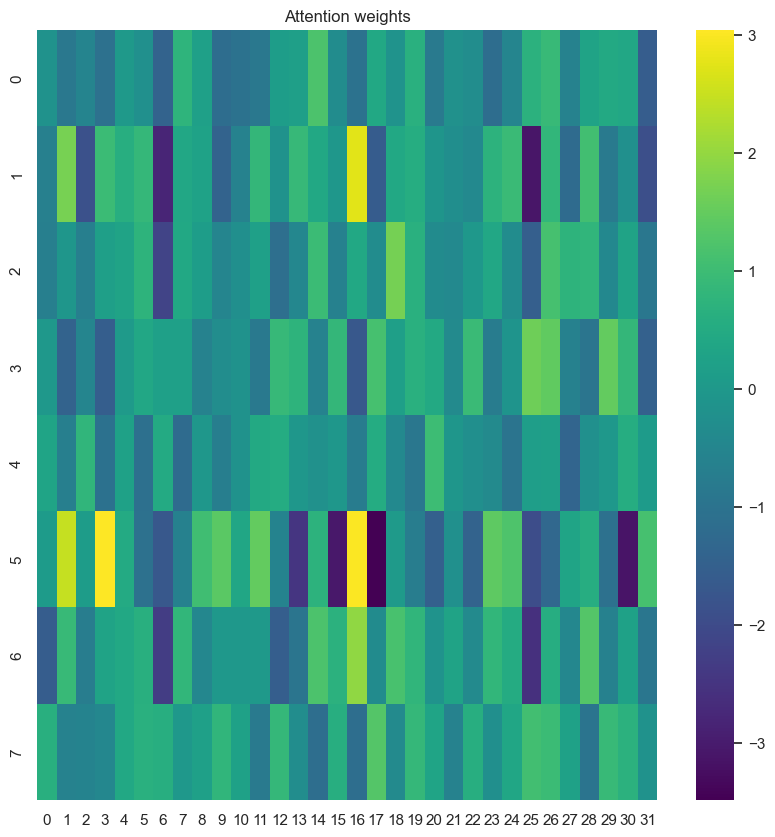

In [140]:
# plotting the attention weights
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# get the next batch
xb, yb = get_batches("val")
xb, yb = xb.to(device), yb.to(device)
# forward the model
B, T = xb.shape
token_embeddings = model.token_embedding_table(xb) # (B,T,C)
position_embeddings = model.positional_embedding_table(torch.arange(T, device=device)) # (T,C)
x = token_embeddings + position_embeddings # (B,T,C)
attention = model.blocks[0].self_attention
weights = attention(x) # (B,T,C)
weights = weights[0].cpu().detach().numpy() # (T,T)
plt.figure(figsize=(10,10))
sns.heatmap(weights, cmap='viridis')
plt.title('Attention weights')
plt.show()

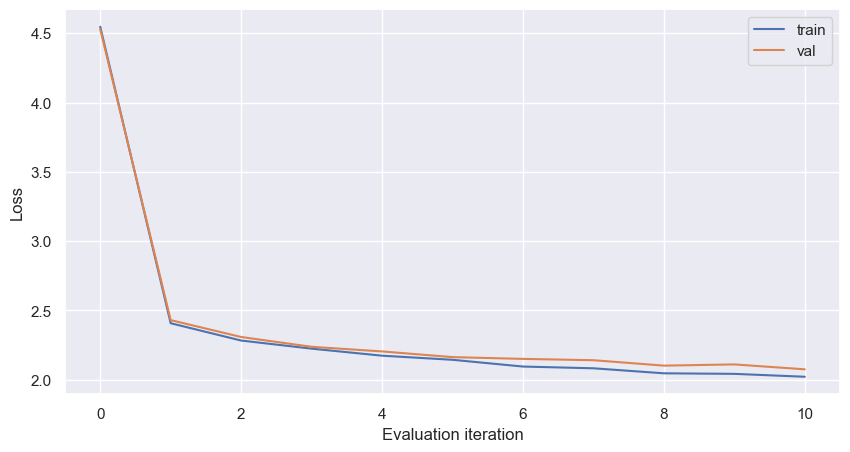

In [141]:
# plotting the losses
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.xlabel('Evaluation iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [147]:
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(model.generate(context, max_new_tokens=1000)[0].tolist()))



OF Tithine
That I molly do offer. Boke if.
O, our debein.

KE VO:
Wer lored noth thas guctor the yepou do care of tour dak, Meentt to grease ougant.

LAMENA:
Thouch ong, o.
For dies,
It fold a heree weath dasay this he hem ey thy with qursburd, if,
Blave af teer
And, letys thellonnd, for wit vere imon didi, su the, one dothigh chaur how, hilly wrich lecreen hemars
pothe the fecenderd a
That dagit, seve gee porrait, Powt buand,
Thit cecriecion, seds, hoave, villy the more, griis kiltind maken th the fartave he plefarling;
Nath of norss,
Lot lards!

KICJY Lost I cand set it and cacloge a rem inius nothign''d Spost of hise bodd me, In by lrewery lapaves
Annowe hamm: I arall lords you
Turs shathern;
whenour of Lennow annich eeve speing. butin hilcevid, in dim wintrise!

And an selfflvin itfin! The deagised make to whe fillse on I me; in hat the tomy, wheyoar plert, your-alace
bast I thou mucker.

BYLENUS:
Bat is the get boy, domed. Ungixing. Fhal, you sbpeag-onto hus quaght?

FLET:
Werve